# Course work: Intro to ML
## Objective: practice the preparation and modeling of data in order to predict the cancellation of hotel bookings
### Collaborative work by Giorgios, Pedro and Marius
### Data can be found at https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

## Step 1: importing libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import xgboost as xgb

## Inspection

In [4]:
# Displaying hidden columns
pd.set_option('display.max_columns', None) 

In [5]:
hotel= pd.read_csv("../input/hotel-booking-demand/hotel_bookings.csv")
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [6]:
hotel.shape

(119390, 32)

# Data Understanding

In [7]:
#Column names
print("Column Names:")
print(hotel.columns)

Column Names:
Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')


## Describing the ambiguous columns, as documented on kaggle: 
- `hotel` : There are only two hotel types: Resort Hotel or City Hotel
- `is_canceled` : "Value indicating if the booking was canceled (1) or not (0)
- `lead_time`: Number of days that elapsed between the entering date of the booking into the PMS and the arrival date
- `stays_in_weekend_nights`: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- `stays_in_week_nights`: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- `meal`: Type of meal booked. Categories are presented in standard hospitality meal packages: 
    - Undefined/SC – no meal package
    - BB – Bed & Breakfast
    - HB – Half board (breakfast and one other meal – usually dinner)
    - FB – Full board (breakfast, lunch and dinner)
- `country`: Country of origin. Categories are represented in the ISO 3155–3:2013 format
- `market_segment`: Market segment designation. 
    - “TA” means “Travel Agents”
    - “TO” means “Tour Operators”
- `distribution_channel`: Booking distribution channel. 
    - “TA” means “Travel Agents”
    - “TO” means “Tour Operators”
- `is_repeated_guest`: Value indicating if the booking name was from a repeated guest (1) or not (0)
- `previous_cancellations`: Number of previous bookings that were cancelled by the customer prior to the current booking
- `previous_bookings_not_canceled`: Number of previous bookings not cancelled by the customer prior to the current booking
- `reserved_room_type`: Code of room type reserved.
- `assigned_room_type`: Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request.
- `booking_changes`: Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
- `deposit_type`: Indication on if the customer made a deposit to guarantee the booking. 
    - This variable can assume three categories: 
    - No Deposit – no deposit was made
    - Non Refund – a deposit was made in the value of the total stay cost
    - Refundable – a deposit was made with a value under the total cost of stay
- `agent`: ID of the travel agency that made the booking
- `company`: ID of the company/entity that made the booking or responsible for paying the booking.
- `days_in_waiting_list`: Number of days the booking was in the waiting list before it was confirmed to the customer
- `customer_type`: Type of booking, assuming one of four categories: 
    - Contract - when the booking has an allotment or other type of contract associated to it
    - Group – when the booking is associated to a group
    - Transient – when the booking is not part of a group or contract, and is not associated to other Transient parties
    - Transient Party - ...
- `Transient-party`: When the booking is transient, but is associated to at least other transient booking
- `adr`: Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights
- `required_car_parking_spaces`: Number of car parking spaces required by the customer
- `total_of_special_requests`: Number of special requests made by the customer (e.g. twin bed or high floor)
- `reservation_status`: Reservation last status, assuming one of three categories: 
    - Canceled – booking was canceled by the customer
    - Check-Out – customer has checked in but already departed
    - No-Show – customer did not check-in and did inform the hotel of the reason why
- `reservation_status_date`: Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel

### Questions

How and by whom booking is made: 
* transient ? meaning
* customer type ? meaining

! Very few people going with booking for non refundable `deposit_type`. counter intuitive ??

### Candidates for feature engineering:

`previous_cancellations` and `previous_bookings_not_canceled` as a ratio ? 

`babies` and `children` encoded as true or false for `with_young_ones` not good will lose information.

`reserved_room_type` vs `assigned_room_type` encoded as `assigned_as_reserved` - whether the same room assigned as reserved
could be more useful as 0:not, 1:yes, 2:upgrade (but we dont have this information of number meaning - order and hierarchy).this does not make sence because the rrom is assigned only if the the bokking is not canceled so we will drop this column

~Forget about it. dont have date of booking in calendar and can't be computed. Canceled date (computed from `Reservation_status` = canceled filtered, then looking at `Reservation_status_date`) could be converted in lead time absolute value difference, or lead time into a date. this way can have a new variable: canceled how much ahead of time. dosent make sence because we drop the columns Reservation_status_date and Reservation_status

### Potentially explainable columns/ predictors ? T-test/Regression style 

`is_cancelled`

`deposit_type`

`is_repeated_guest`

`booking_changes` - booking # of changes

`days_in_waiting_list`


### Alg selection:


Regression with very few independent variables


K-Means requires scaling for best results


Decision tree uses thresholds, so does not consider as continous the ones that are categorical encoded

* depth and over fitting


Naive Bays ?



# handle missing values


In [8]:

hotel.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [9]:
hotel.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0


In [10]:
#Checking the missing values

hotel.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [11]:
#missing values as a percentage
null_values_percentage = (hotel.isnull().sum()/len(hotel))*100 
null_values_percentage

hotel                              0.000000
is_canceled                        0.000000
lead_time                          0.000000
arrival_date_year                  0.000000
arrival_date_month                 0.000000
arrival_date_week_number           0.000000
arrival_date_day_of_month          0.000000
stays_in_weekend_nights            0.000000
stays_in_week_nights               0.000000
adults                             0.000000
children                           0.003350
babies                             0.000000
meal                               0.000000
country                            0.408744
market_segment                     0.000000
distribution_channel               0.000000
is_repeated_guest                  0.000000
previous_cancellations             0.000000
previous_bookings_not_canceled     0.000000
reserved_room_type                 0.000000
assigned_room_type                 0.000000
booking_changes                    0.000000
deposit_type                    

In [12]:
#lets drop the column company 
hotel.drop(columns=['company'], inplace= True )

In [13]:
# beacause the percentage of nan values is really low lets errase the nana instances of this 2 columns
hotel.dropna(subset=  ['children','country'], inplace = True)

In [14]:
#since agent is a ID category we substitute the nan values with the mode
hotel.fillna(hotel['agent'].mode()[0], inplace = True)


In [15]:
# lets see if the nan values where handeled
hotel.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces 

In [16]:
len(hotel)

118898

In [17]:
# calculate the percentual reduction after erasing observations
((118898-119390)/119390)*100

-0.4120948153111651

We can therefore conclude that the data does not present significant missing values (defined as)

We therefore continue to encoding, scaling and reformatting the data - ready for modeling.

# lets handle some inconsistencies of the data and irrelevat features

In [18]:
# in some instances the stays_in_weekend_nights and stays_in_week_nights are both 0 that cant be by logic so we errase all record where this hapens
hotel = hotel[(hotel['stays_in_weekend_nights'] != 0) | (hotel['stays_in_week_nights'] != 0)]

In [19]:
# the column assigned_room_type dosent make sence in this problem because a room only is assigned on the chack in day that means the boking is not canceled, so this is not a good predictor 
hotel.drop(columns=['assigned_room_type'], inplace= True )

In [20]:
#see if there is negative adr values
hotel[hotel['adr']<0]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
14969,Resort Hotel,0,195,2017,March,10,5,4,6,2,0.0,0,BB,GBR,Groups,Direct,1,0,2,A,2,No Deposit,273.0,0,Transient-Party,-6.38,0,0,Check-Out,2017-03-15


In [21]:
# there is one negative adr value wich does not make senceReplace negative adr with median of adr column
hotel.loc[hotel['adr'] < 0, 'adr'] = hotel['adr'].median()

In [22]:
#see if there is reservations without adults
len(hotel[hotel['adults']==0])


332

there is 332 bookings without any adults well this may be because in portugal some hotels allow you to make a reservation if you are above 16 so les assume that the 2 hotels in the data allow reservation for under 18 

In [23]:
#from the descriptive statistics we see that the max of childeren and babys is 10 lets see how many instancies have this number 
len(hotel[hotel['children']==10]) , len(hotel[hotel['babies']==10] )

(1, 1)

In [24]:
# since we only have 1 instance for tose outliers childeren and babies we will remove them from the data 
hotel = hotel[hotel['children'] != 10]
hotel = hotel[hotel['babies'] != 10]

In [25]:
#lets confirm if the noisy data was handeled
len(hotel[hotel['children']==10]) , len(hotel[hotel['babies']==10] ) ,len( hotel[hotel['adr']<0])

(0, 0, 0)

the columns reservation_status_date and reservation_status give us the same information as the target variable since the reservation status has 3 categories checkd out, 

In [26]:
# lets see again what variables do we have
hotel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118195 entries, 2 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           118195 non-null  object 
 1   is_canceled                     118195 non-null  int64  
 2   lead_time                       118195 non-null  int64  
 3   arrival_date_year               118195 non-null  int64  
 4   arrival_date_month              118195 non-null  object 
 5   arrival_date_week_number        118195 non-null  int64  
 6   arrival_date_day_of_month       118195 non-null  int64  
 7   stays_in_weekend_nights         118195 non-null  int64  
 8   stays_in_week_nights            118195 non-null  int64  
 9   adults                          118195 non-null  int64  
 10  children                        118195 non-null  float64
 11  babies                          118195 non-null  int64  
 12  meal                 

## Feature engineering and feature selction starts here

In [27]:
# copy hotel dataframe into a new one that will be engineered
hotel_eng = pd.DataFrame()
hotel_eng = hotel.copy()

In [28]:
#first lets start by transforming the months colum into a numerical one mapping the names of the months into the month number
month_to_number = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

# Map month names to month numbers using the dictionary
hotel_eng['arrival_date_month'] = hotel_eng['arrival_date_month'].map(month_to_number)


In [29]:
#lets combine the 3 arrival colums into a single one named arrival_date 
hotel_eng['arrival_date'] = pd.to_datetime(hotel_eng['arrival_date_year'].astype(str) + '-' + 
                                    hotel_eng['arrival_date_month'].astype(str) + '-' + 
                                    hotel_eng['arrival_date_day_of_month'].astype(str))

In [30]:
hotel_eng.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
2,Resort Hotel,0,7,2015,7,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,0,No Deposit,9.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
3,Resort Hotel,0,13,2015,7,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
4,Resort Hotel,0,14,2015,7,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01
5,Resort Hotel,0,14,2015,7,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01
6,Resort Hotel,0,0,2015,7,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,0,No Deposit,9.0,0,Transient,107.0,0,0,Check-Out,2015-07-03,2015-07-01


In [31]:
#since we now have the arrive month as a number the column we can drop the arrival_date_week_number since they basically have the same information
hotel_eng.drop(columns=['arrival_date_week_number'], inplace= True )


In [32]:
#show the categories in the reservation_status
hotel_eng['reservation_status'].unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

 the columns reservation_status and reservation_status_date should not be used to predict whether the booking will be canceled or not because the contain direct information about the dependent variable. tjis is because reservation_status only has 3 possible values being checkd out meaning the booking was not canceled, Canceled meaning the boking was canceled and no.show that is also considered canceled. and the reservation_status_date has the particularity of in the checked-out cases be superior to the arrival date in the canceled cases be less than the arrival date. so using this columns to do predictions will result in a massive data leakage. for that reason those columns will be droped.

In [33]:
# droping the 2 columns mentioned above

hotel_eng.drop(columns=['reservation_status','reservation_status_date'], inplace= True )


# lets make some EDA

In [34]:
hotel_eng.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'deposit_type', 'agent', 'days_in_waiting_list',
       'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'arrival_date'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


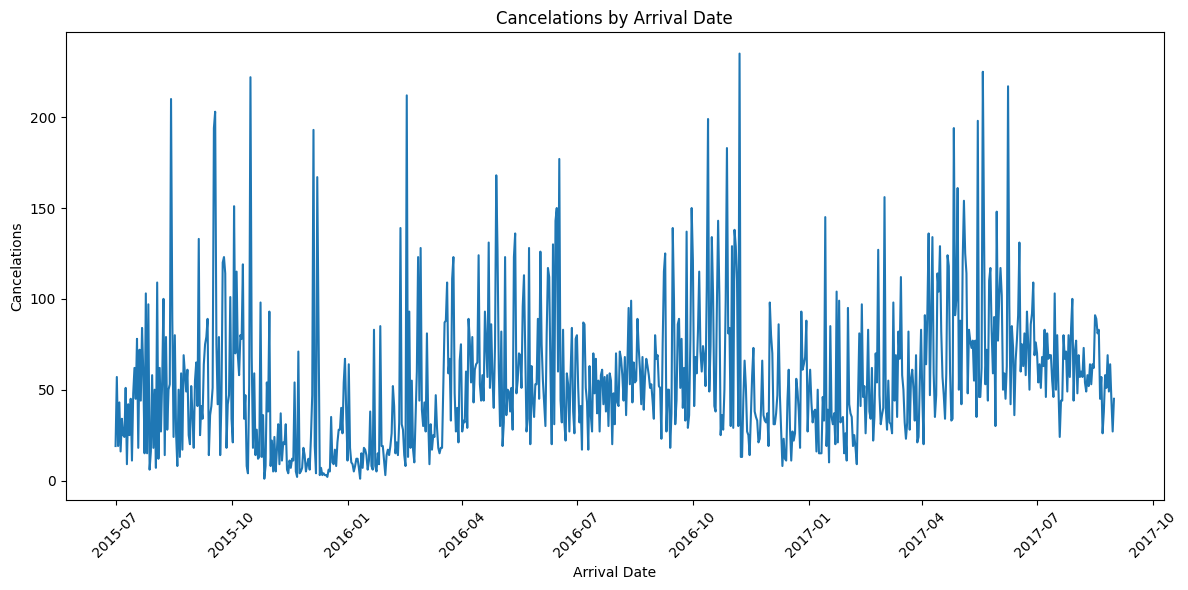

In [35]:
#see the time distribution of cancelations
cancelations_by_date = hotel_eng.groupby('arrival_date')['is_canceled'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x='arrival_date', y='is_canceled', data=cancelations_by_date)
plt.title('Cancelations by Arrival Date')
plt.xlabel('Arrival Date')
plt.ylabel('Cancelations')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


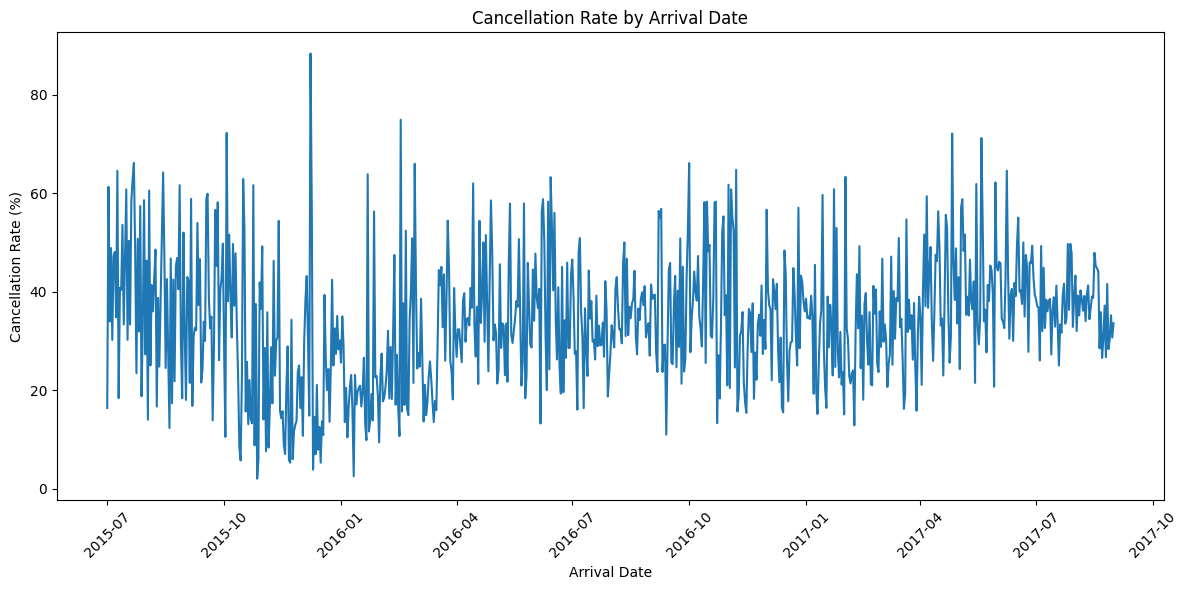

In [36]:
#showing the cancelation rate to have a notion of the structure 
import matplotlib.dates as mdates
cancellation_rate_by_date = hotel_eng.groupby('arrival_date')['is_canceled'].mean() * 100

# Resetting index to convert the result to a DataFrame
cancellation_rate_by_date = cancellation_rate_by_date.reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x='arrival_date', y='is_canceled', data=cancellation_rate_by_date)
plt.title('Cancellation Rate by Arrival Date')
plt.xlabel('Arrival Date')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


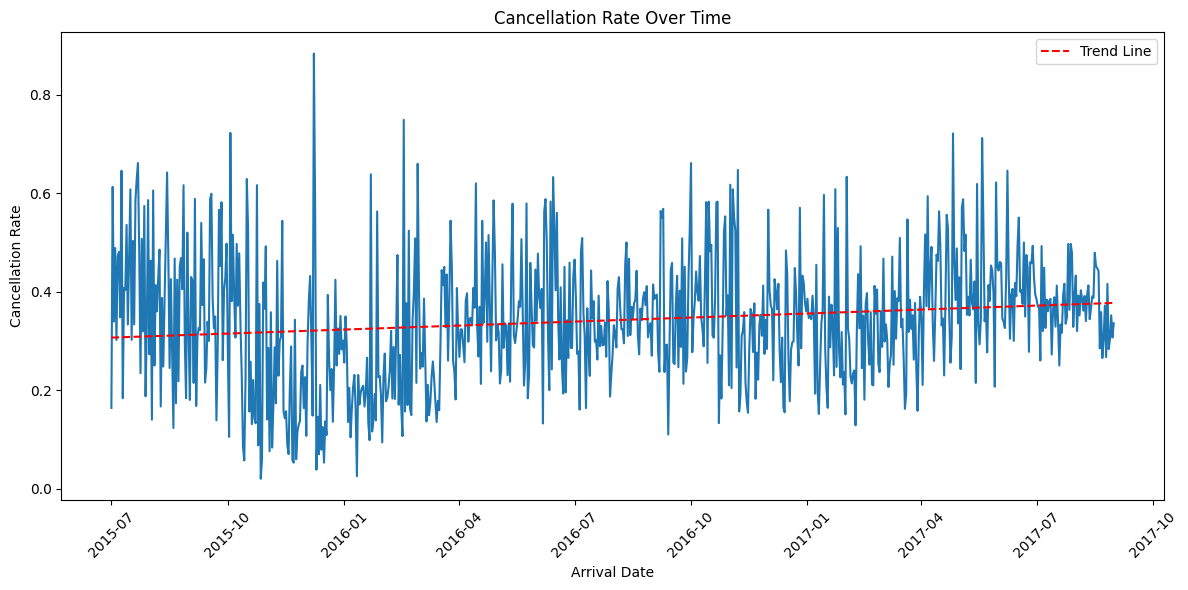

In [37]:
# the same but with a trend line
cancellation_rate_by_date = hotel_eng.groupby('arrival_date')['is_canceled'].mean()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x=cancellation_rate_by_date.index, y=cancellation_rate_by_date.values)

# Fit a trend line (linear regression)
trend_x = np.arange(len(cancellation_rate_by_date))
trend_y = np.poly1d(np.polyfit(trend_x, cancellation_rate_by_date.values, 1))(trend_x)
plt.plot(cancellation_rate_by_date.index, trend_y, color='red', linestyle='--', label='Trend Line')

plt.title('Cancellation Rate Over Time')
plt.xlabel('Arrival Date')
plt.ylabel('Cancellation Rate')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

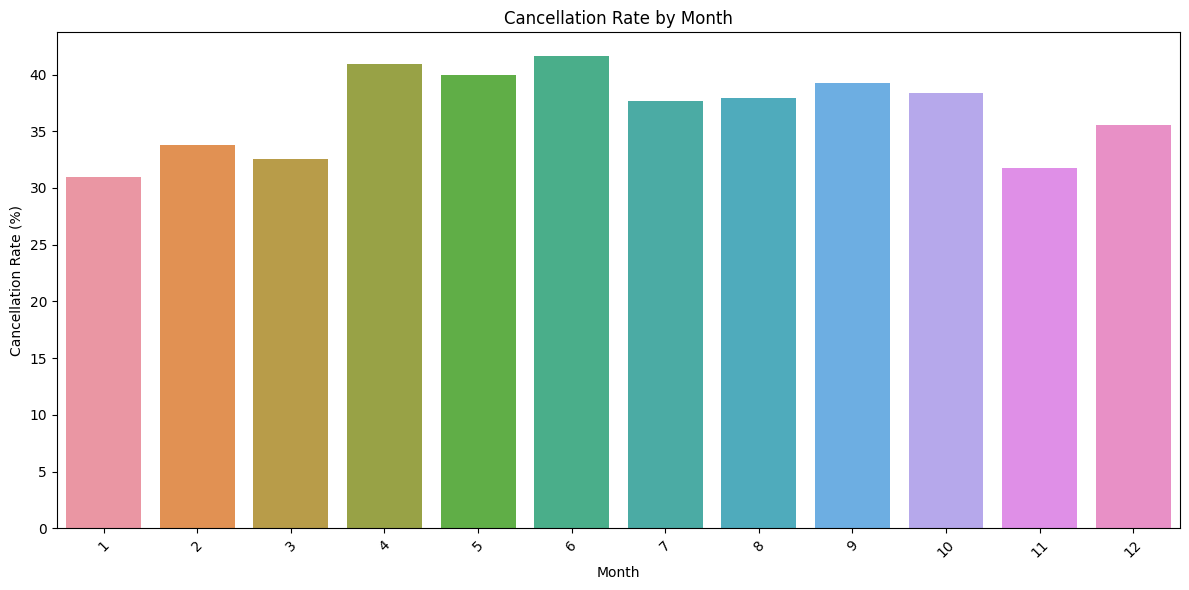

In [38]:
cancellation_rate_by_month = hotel_eng.groupby('arrival_date_month')['is_canceled'].mean() * 100

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=cancellation_rate_by_month.index, y=cancellation_rate_by_month.values)
plt.title('Cancellation Rate by Month')
plt.xlabel('Month')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

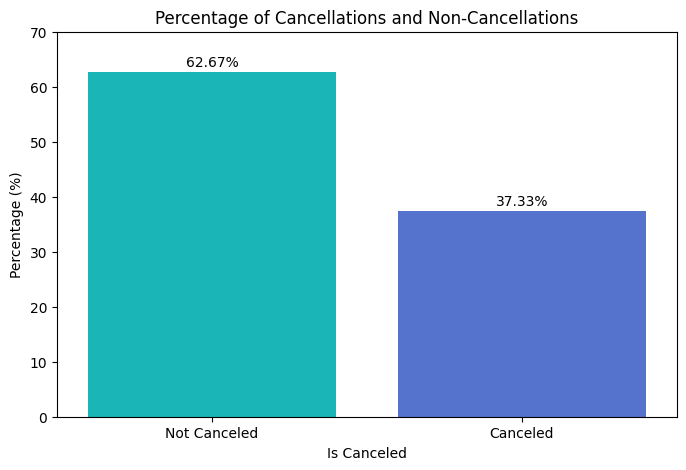

In [39]:
# Calculating the percentage of each class
percentage = hotel_eng['is_canceled'].value_counts(normalize=True) * 100

# Plotting the percentage of each class
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=percentage.index, y=percentage, palette=['darkturquoise', 'royalblue'])
plt.title('Percentage of Cancellations and Non-Cancellations')
plt.xlabel('Is Canceled')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled'])
plt.yticks(ticks=range(0,80,10))

# Displaying the percentage on the bars
for i, p in enumerate(percentage):
    ax.text(i, p + 0.5, f'{p:.2f}%', ha='center', va='bottom')

plt.show()

In [40]:
hotel_eng.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'deposit_type', 'agent', 'days_in_waiting_list',
       'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'arrival_date'],
      dtype='object')

# now that we have visualized the data by date we can drop the columns arrival_date_year beacause we only have 3 years and our objective is not to do a time searies analisis is to predict if a booking wil be canceled or not so including this feature will introduce bias in future prediction by extention the column arrival_date also contais the year so ww will drop it as well

In [41]:
hotel_eng_ny=hotel_eng.drop(columns=['arrival_date','arrival_date_year'],axis=1)

In [42]:
#lets select the categorical coluns to make some count plots
hotel_eng_ny_cat = hotel_eng_ny.select_dtypes(include=['object'])
hotel_eng_ny_cat

,hotel,meal,country,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type
2,Resort Hotel,BB,GBR,Direct,Direct,A,No Deposit,Transient
3,Resort Hotel,BB,GBR,Corporate,Corporate,A,No Deposit,Transient
4,Resort Hotel,BB,GBR,Online TA,TA/TO,A,No Deposit,Transient
5,Resort Hotel,BB,GBR,Online TA,TA/TO,A,No Deposit,Transient
6,Resort Hotel,BB,PRT,Direct,Direct,C,No Deposit,Transient
...,...,...,...,...,...,...,...,...
119385,City Hotel,BB,BEL,Offline TA/TO,TA/TO,A,No Deposit,Transient
119386,City Hotel,BB,FRA,Online TA,TA/TO,E,No Deposit,Transient
119387,City Hotel,BB,DEU,Online TA,TA/TO,D,No Deposit,Transient
119388,City Hotel,BB,GBR,Online TA,TA/TO,A,No Deposit,Transient


In [43]:
#lets make the same for the numerical variables
hotel_eng_ny_num=hotel_eng_ny.drop(columns=hotel_eng_ny_cat.columns )
hotel_eng_ny_num

,is_canceled,lead_time,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
2,0,7,7,1,0,1,1,0.0,0,0,0,0,0,9.0,0,75.00,0,0
3,0,13,7,1,0,1,1,0.0,0,0,0,0,0,304.0,0,75.00,0,0
4,0,14,7,1,0,2,2,0.0,0,0,0,0,0,240.0,0,98.00,0,1
5,0,14,7,1,0,2,2,0.0,0,0,0,0,0,240.0,0,98.00,0,1
6,0,0,7,1,0,2,2,0.0,0,0,0,0,0,9.0,0,107.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,8,30,2,5,2,0.0,0,0,0,0,0,394.0,0,96.14,0,0
119386,0,102,8,31,2,5,3,0.0,0,0,0,0,0,9.0,0,225.43,0,2
119387,0,34,8,31,2,5,2,0.0,0,0,0,0,0,9.0,0,157.71,0,4
119388,0,109,8,31,2,5,2,0.0,0,0,0,0,0,89.0,0,104.40,0,0


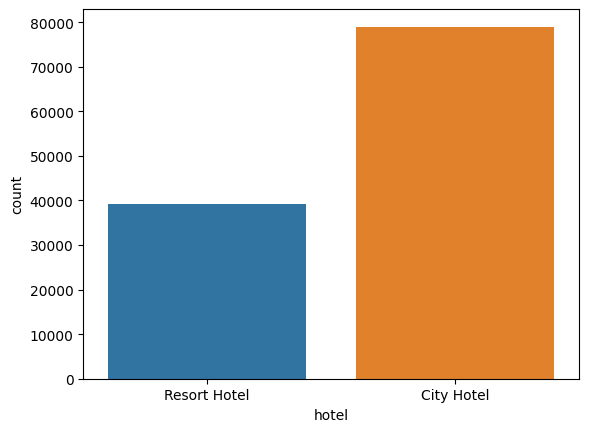

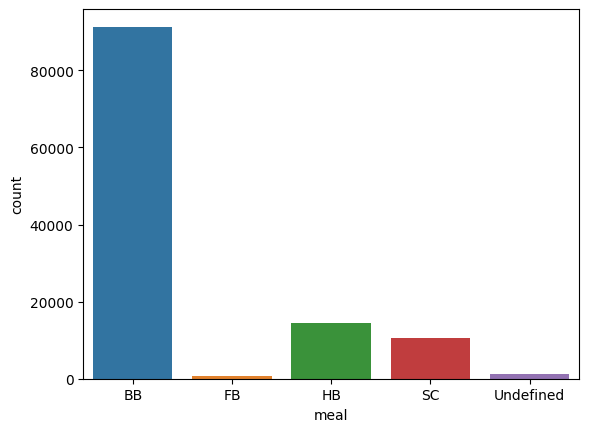

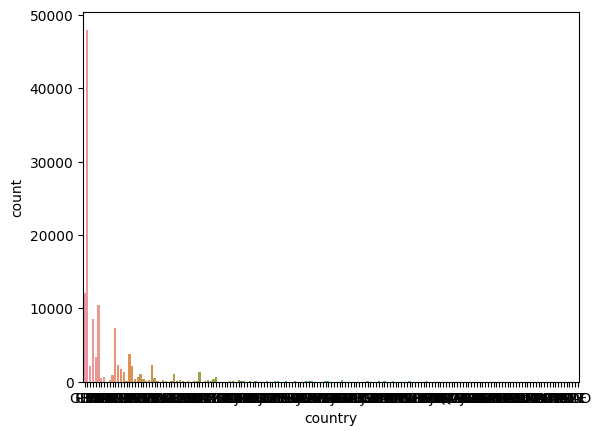

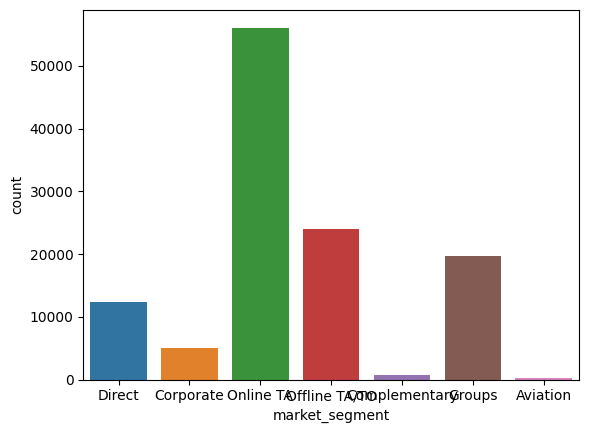

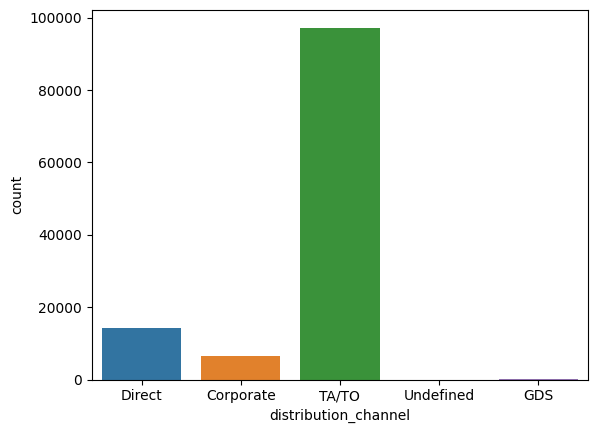

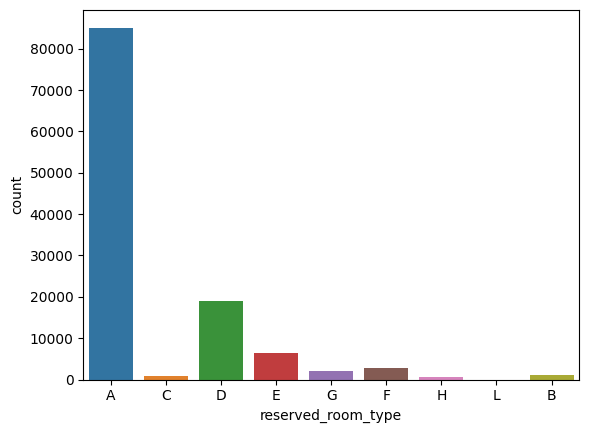

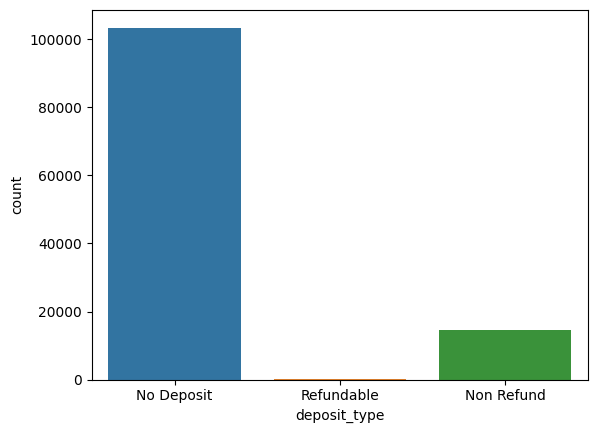

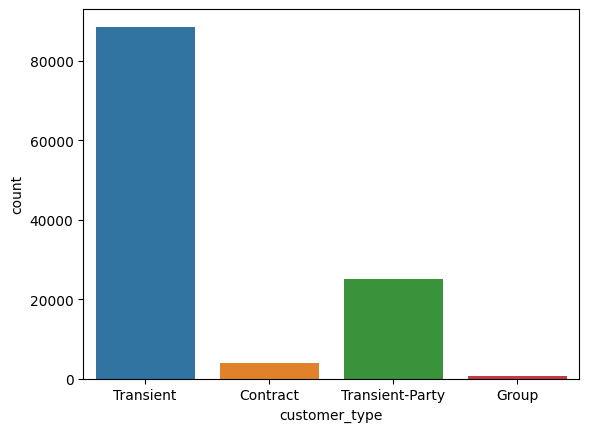

In [44]:
#make and visualize the countplots
countplots = []
for column in hotel_eng_ny_cat.columns:
    plt.figure()  # Create a new figure for each countplot
    countplots.append(sns.countplot(data=hotel_eng_ny_cat, x=column))

# Show all countplots
plt.show()

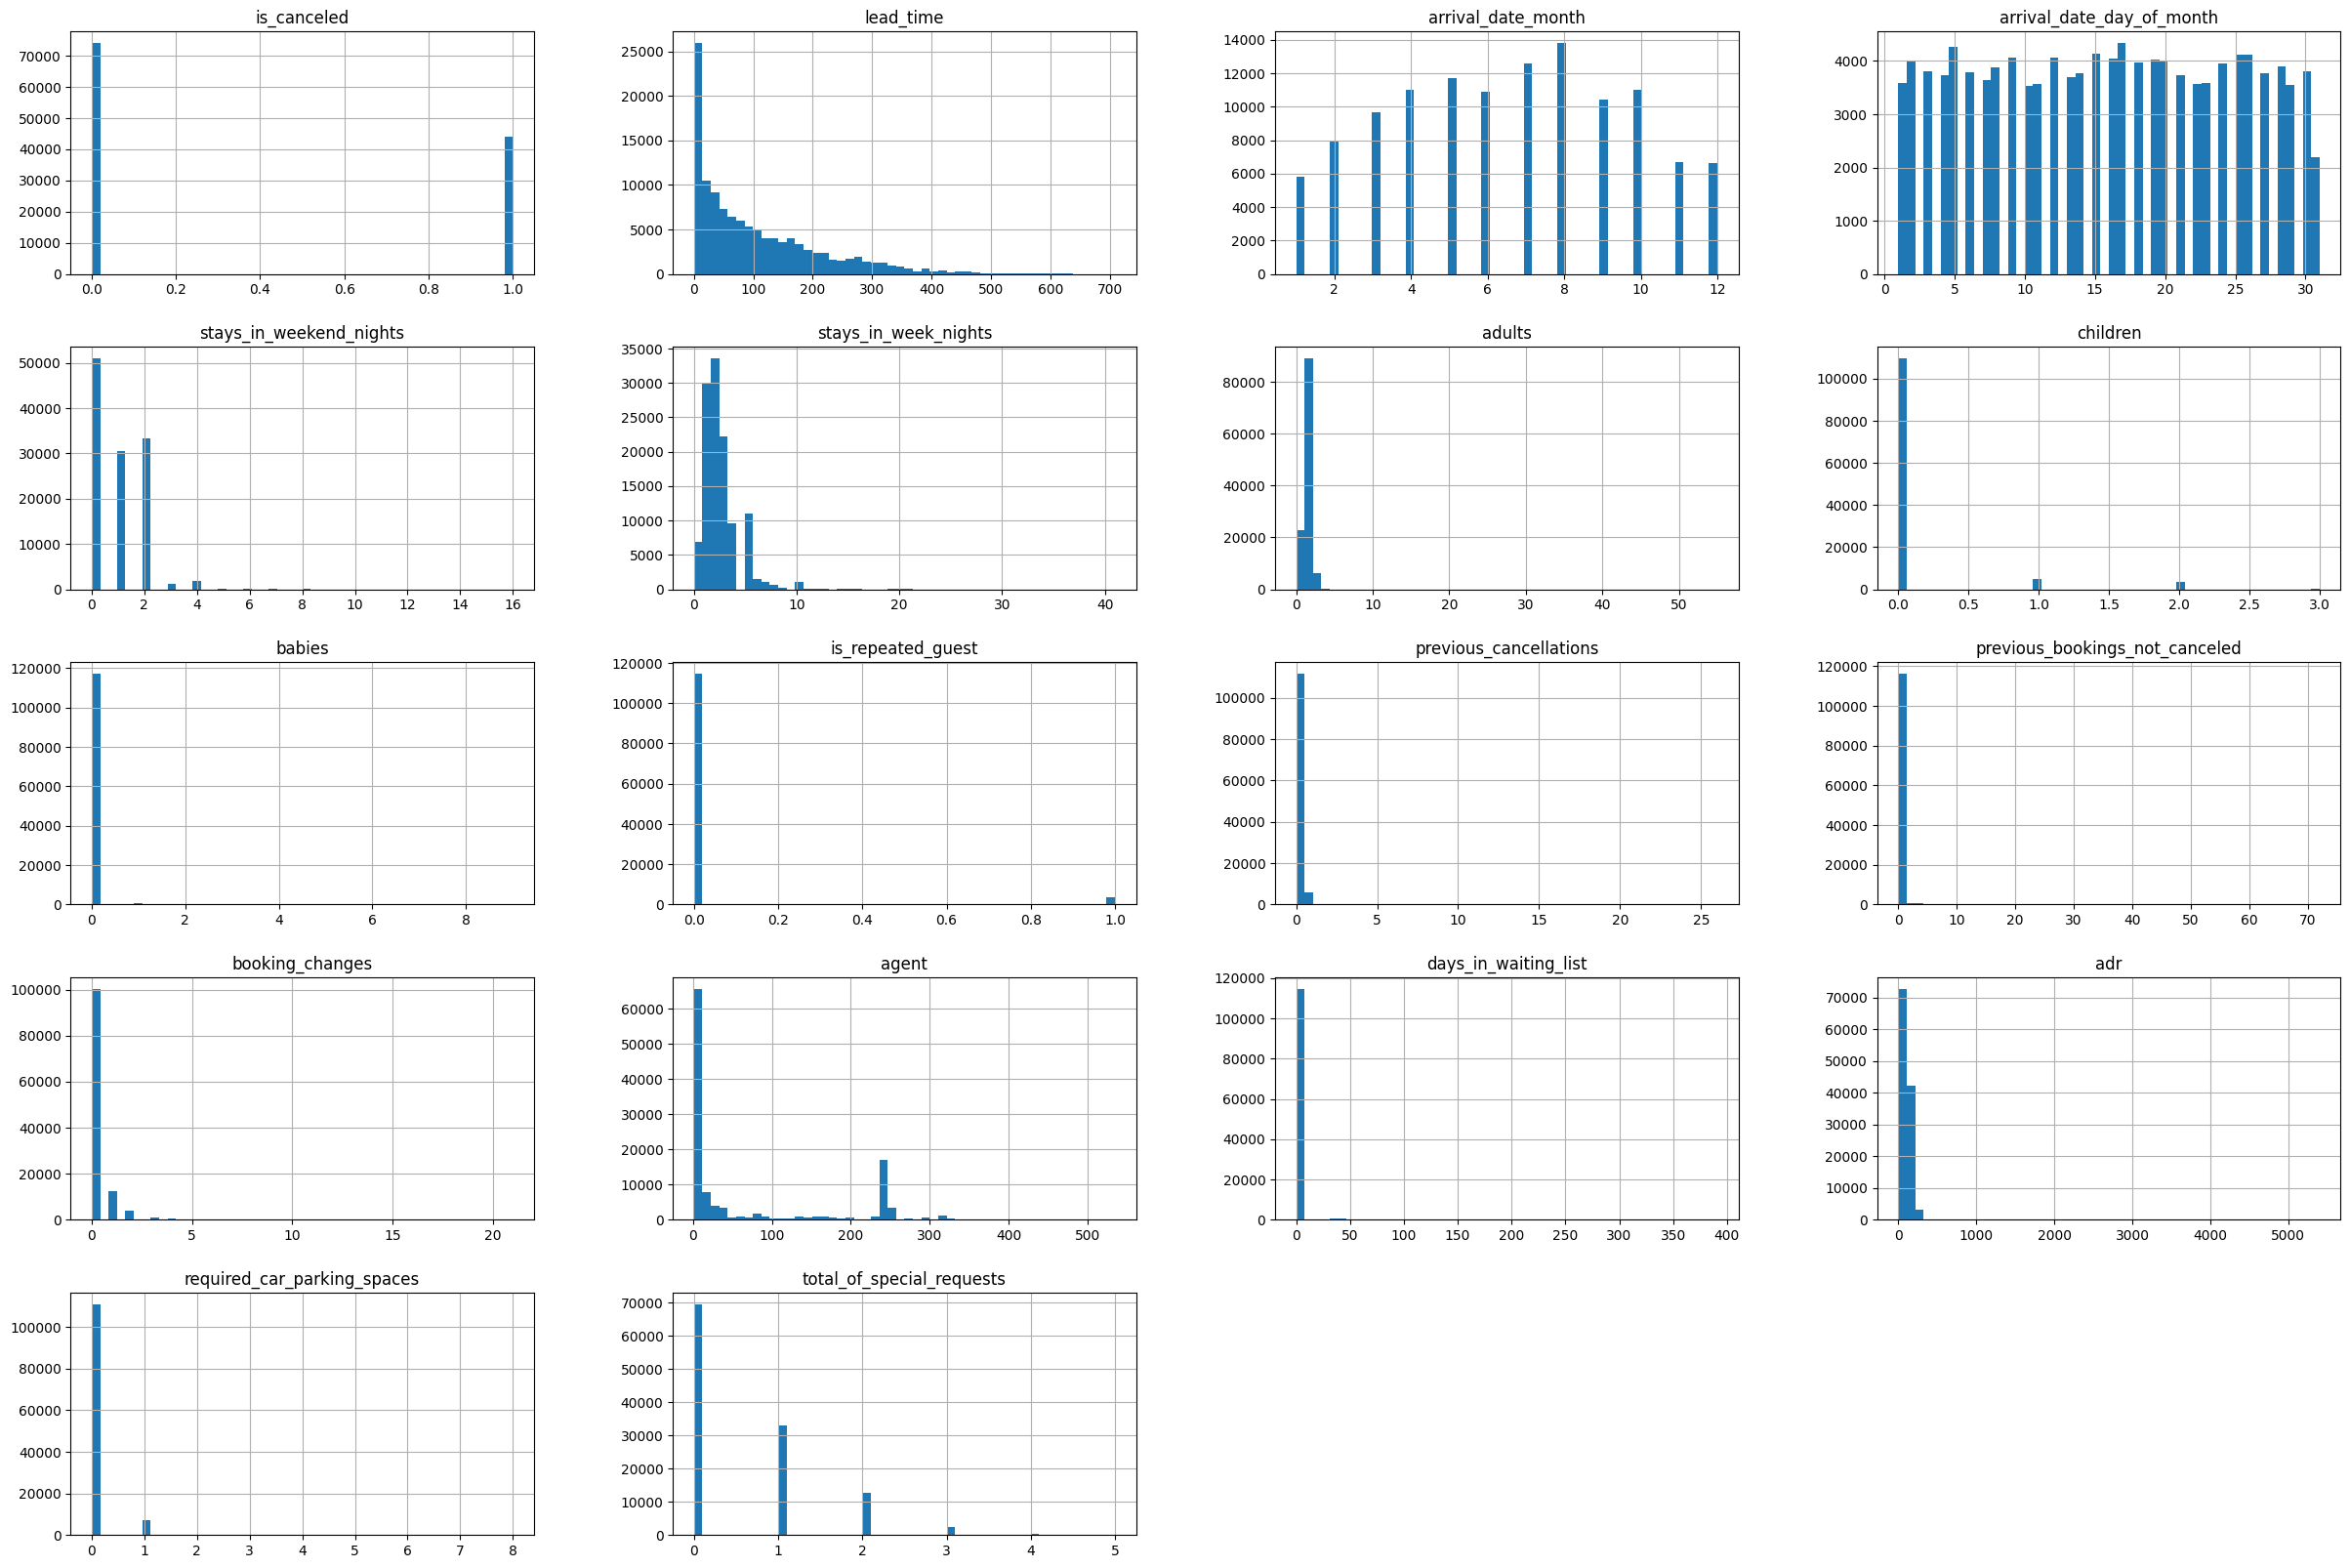

In [45]:
#now lets make some histograms for the numerical variables
hotel_eng_ny_num.hist(bins=50, figsize=(30,20))
plt.show()

from this histograms we can conclude that in this data there are way more city hotels that resort hotels

the majoroty of the reservations is made near the date of the check in.

the majoroty of bookings where made in 2016 and june and jully are the moths that hold more bookings each year.

usualy each boking is made for 2 adults and there are no babys or childeren

also its really comun that the boking was made by someone that has not made a reservation in that hotel and with no previous cancelations.

in adition there are almoast no boking_changes and the days in waiting list are mostly 0

In [46]:
hotel_eng_ny_num.head()

,is_canceled,lead_time,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
2,0,7,7,1,0,1,1,0.0,0,0,0,0,0,9.0,0,75.0,0,0
3,0,13,7,1,0,1,1,0.0,0,0,0,0,0,304.0,0,75.0,0,0
4,0,14,7,1,0,2,2,0.0,0,0,0,0,0,240.0,0,98.0,0,1
5,0,14,7,1,0,2,2,0.0,0,0,0,0,0,240.0,0,98.0,0,1
6,0,0,7,1,0,2,2,0.0,0,0,0,0,0,9.0,0,107.0,0,0


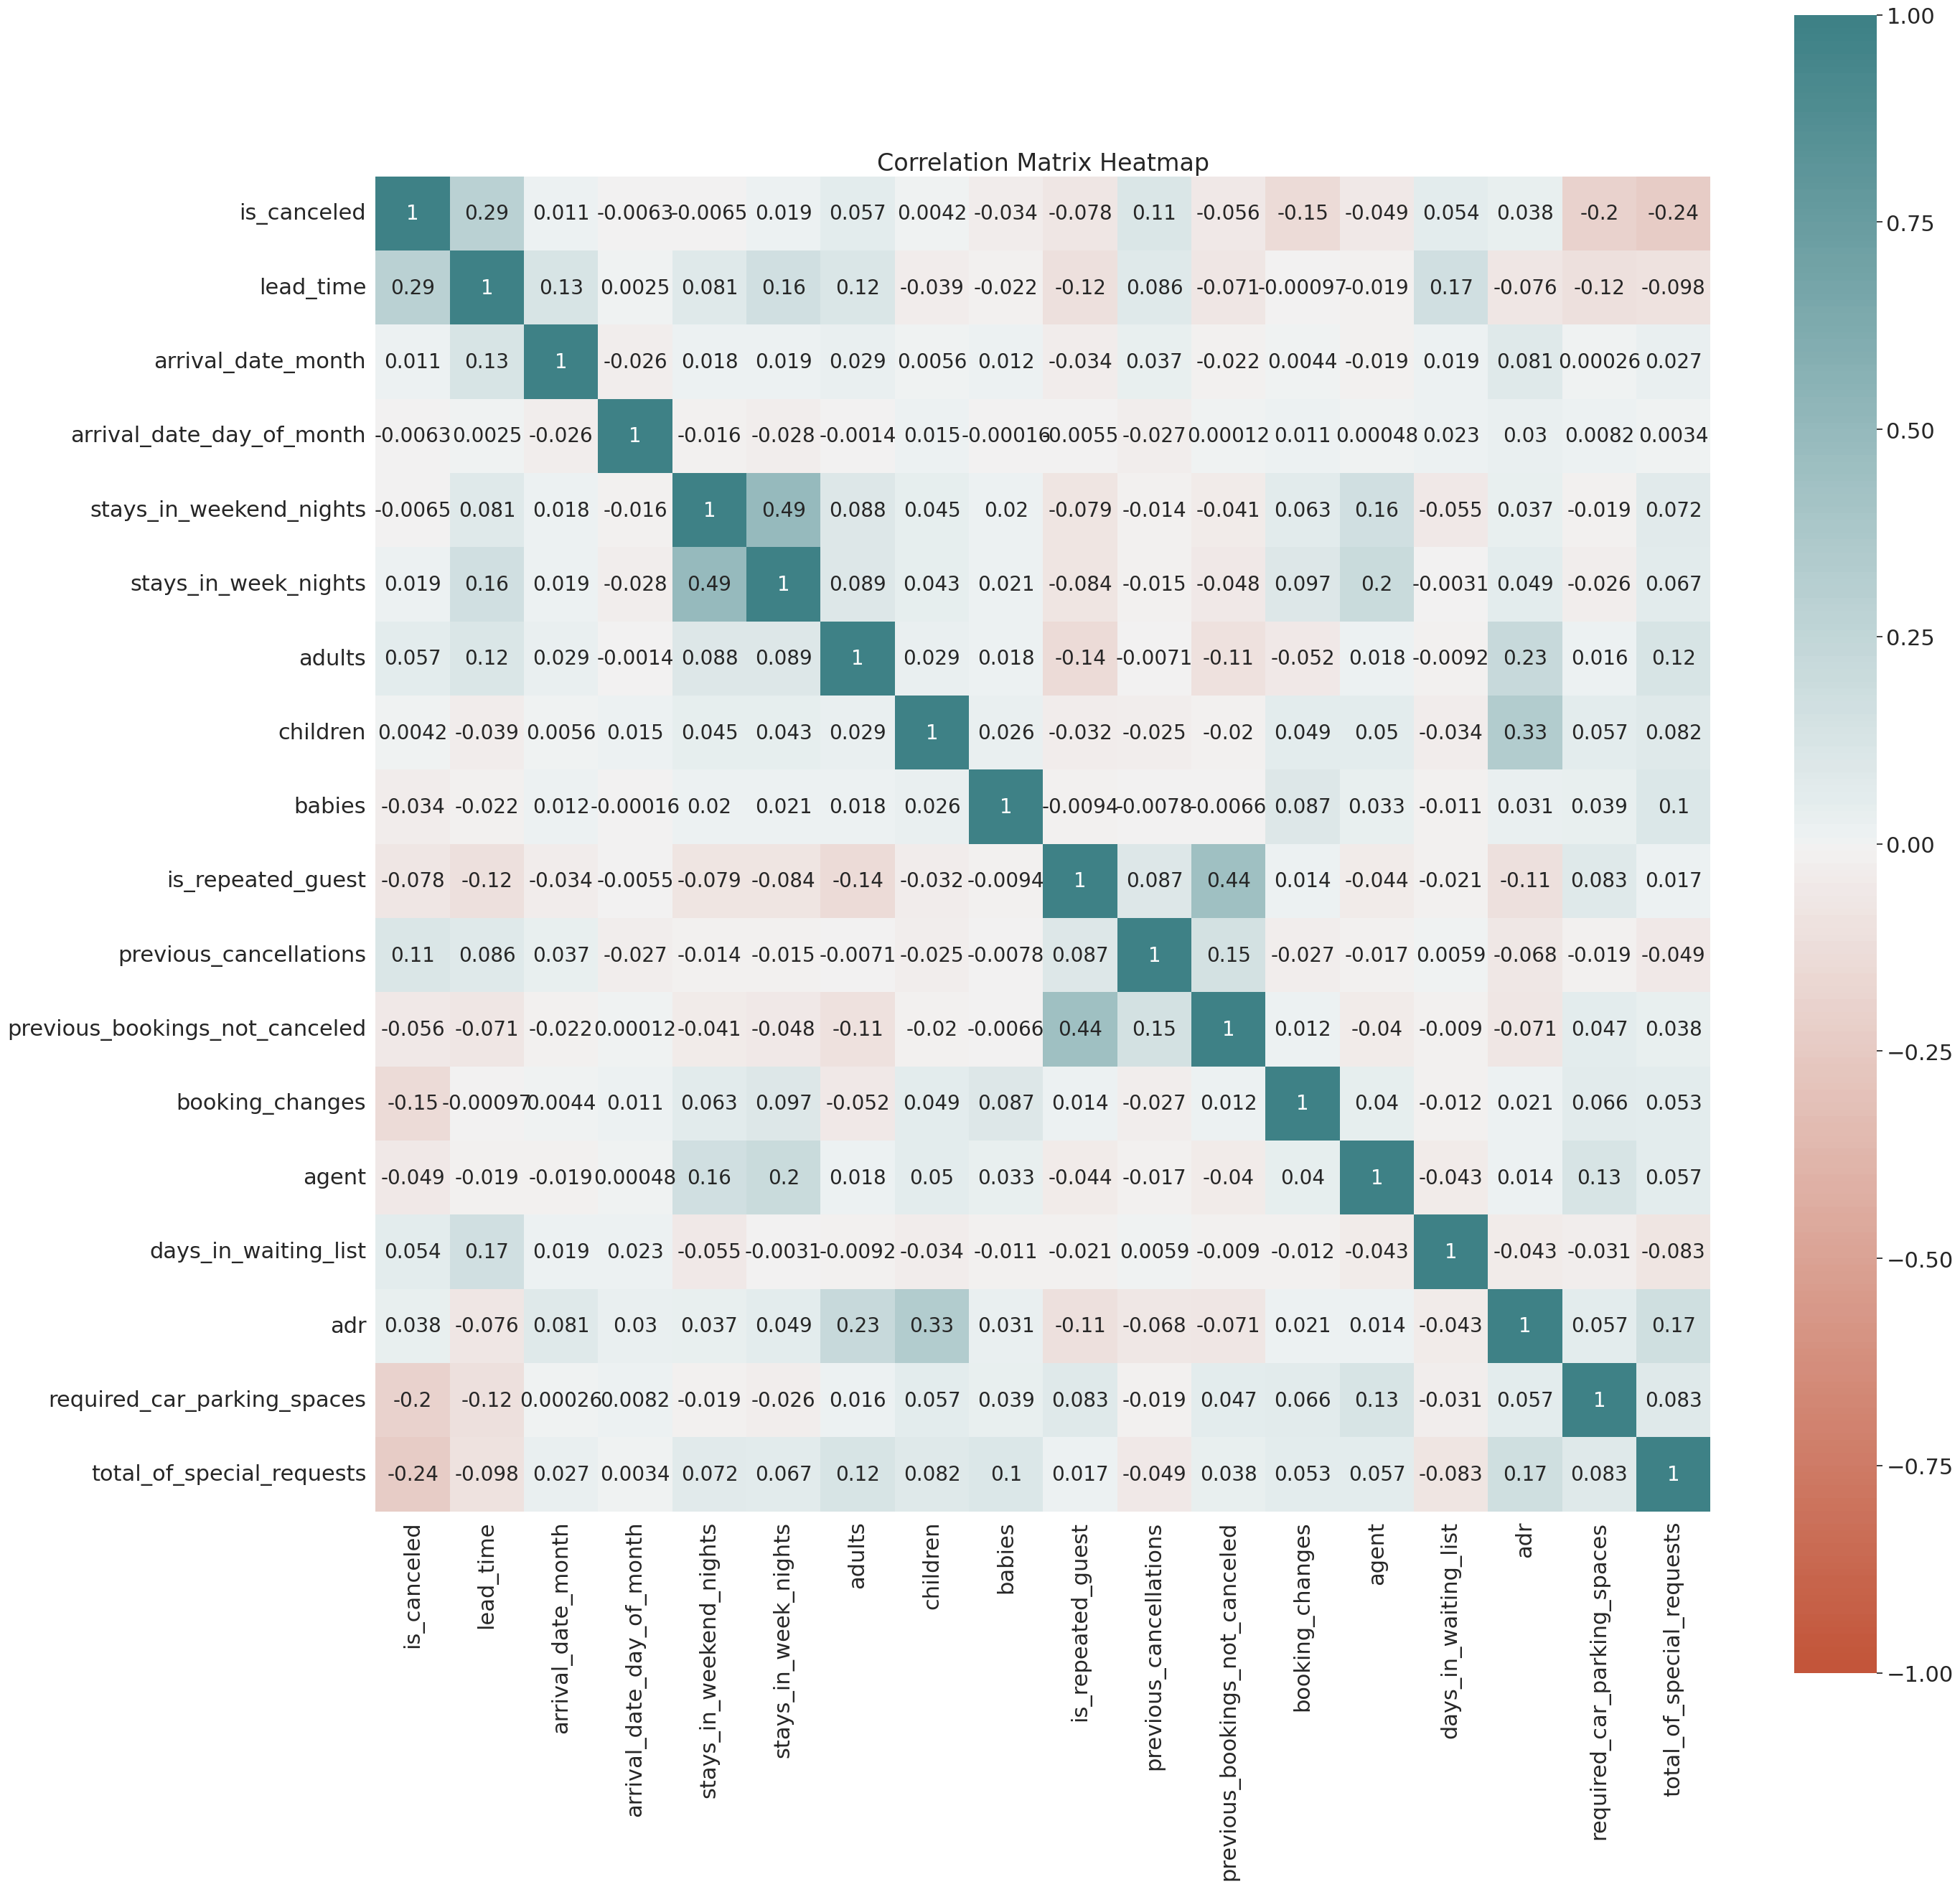

In [47]:
# Plot correlation matrix
cormat = hotel_eng_ny_num.corr()

plt.figure(figsize=(30, 30))
sns.set(font_scale=2.0)
ax = sns.heatmap(
    cormat,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 200, n=200),
    square=True, annot=True, annot_kws={'size': 20}
)
plt.title('Correlation Matrix Heatmap', fontsize=24)
plt.show()

from this correlation matrix we can see that there are no major correlation between the numerical variables


In [48]:
#descriptive stats from the cat variables
hotel_eng_ny_cat.describe().T



,count,unique,top,freq
hotel,118195,2,City Hotel,78977
meal,118195,5,BB,91316
country,118195,177,PRT,47990
market_segment,118195,7,Online TA,56090
distribution_channel,118195,5,TA/TO,97265
reserved_room_type,118195,9,A,85084
deposit_type,118195,3,No Deposit,103460
customer_type,118195,4,Transient,88580


In [49]:
# as can be seen the columns country has 177 observations and a the majoroty are PRT that being said when we use a onehot encoder to this variable it will generate 177 columns and will not introduce relevant information in the model for that reason we will drop this column
hotel_eng_ny_cat.drop(columns=['country'],inplace=True)

In [50]:
hotel_eng_ny_cat

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type
2,Resort Hotel,BB,Direct,Direct,A,No Deposit,Transient
3,Resort Hotel,BB,Corporate,Corporate,A,No Deposit,Transient
4,Resort Hotel,BB,Online TA,TA/TO,A,No Deposit,Transient
5,Resort Hotel,BB,Online TA,TA/TO,A,No Deposit,Transient
6,Resort Hotel,BB,Direct,Direct,C,No Deposit,Transient
...,...,...,...,...,...,...,...
119385,City Hotel,BB,Offline TA/TO,TA/TO,A,No Deposit,Transient
119386,City Hotel,BB,Online TA,TA/TO,E,No Deposit,Transient
119387,City Hotel,BB,Online TA,TA/TO,D,No Deposit,Transient
119388,City Hotel,BB,Online TA,TA/TO,A,No Deposit,Transient


now lets encode the variables dat need to be encoded

hotel: This is a nominal variable with two categories.

meal: This is a nominal variable.

market_segment: This is a nominal variable.

distribution_channel: This is a nominal variable.

reserved_room_type: This is a nominal variable.

deposit_type: This is a nominal variable.

customer_type: This is a nominal variable.

In [51]:
#encode the dummies
X_encoded=pd.get_dummies(hotel_eng_ny_cat)

In [52]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118195 entries, 2 to 119389
Data columns (total 35 columns):
 #   Column                          Non-Null Count   Dtype
---  ------                          --------------   -----
 0   hotel_City Hotel                118195 non-null  bool 
 1   hotel_Resort Hotel              118195 non-null  bool 
 2   meal_BB                         118195 non-null  bool 
 3   meal_FB                         118195 non-null  bool 
 4   meal_HB                         118195 non-null  bool 
 5   meal_SC                         118195 non-null  bool 
 6   meal_Undefined                  118195 non-null  bool 
 7   market_segment_Aviation         118195 non-null  bool 
 8   market_segment_Complementary    118195 non-null  bool 
 9   market_segment_Corporate        118195 non-null  bool 
 10  market_segment_Direct           118195 non-null  bool 
 11  market_segment_Groups           118195 non-null  bool 
 12  market_segment_Offline TA/TO    118195 non-null  

In [53]:
print(type(hotel_eng_ny_num))
print(type(X_encoded))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [54]:
#combining the numerical colums with the encoded variables

data = hotel_eng_ny_num.join(X_encoded, lsuffix='_left', rsuffix='_right')

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118195 entries, 2 to 119389
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     118195 non-null  int64  
 1   lead_time                       118195 non-null  int64  
 2   arrival_date_month              118195 non-null  int64  
 3   arrival_date_day_of_month       118195 non-null  int64  
 4   stays_in_weekend_nights         118195 non-null  int64  
 5   stays_in_week_nights            118195 non-null  int64  
 6   adults                          118195 non-null  int64  
 7   children                        118195 non-null  float64
 8   babies                          118195 non-null  int64  
 9   is_repeated_guest               118195 non-null  int64  
 10  previous_cancellations          118195 non-null  int64  
 11  previous_bookings_not_canceled  118195 non-null  int64  
 12  booking_changes      

In [56]:
data.head()

,is_canceled,lead_time,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,hotel_City Hotel,hotel_Resort Hotel,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
2,0,7,7,1,0,1,1,0.0,0,0,0,0,0,9.0,0,75.0,0,0,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
3,0,13,7,1,0,1,1,0.0,0,0,0,0,0,304.0,0,75.0,0,0,False,True,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
4,0,14,7,1,0,2,2,0.0,0,0,0,0,0,240.0,0,98.0,0,1,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
5,0,14,7,1,0,2,2,0.0,0,0,0,0,0,240.0,0,98.0,0,1,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
6,0,0,7,1,0,2,2,0.0,0,0,0,0,0,9.0,0,107.0,0,0,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False


In [57]:
#now we need to divide the data into y (target variable ) and X independent variables
y = data['is_canceled']
y

2         0
3         0
4         0
5         0
6         0
         ..
119385    0
119386    0
119387    0
119388    0
119389    0
Name: is_canceled, Length: 118195, dtype: int64

In [58]:
X=  data.drop('is_canceled', axis=1)

In [59]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118195 entries, 2 to 119389
Data columns (total 52 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   lead_time                       118195 non-null  int64  
 1   arrival_date_month              118195 non-null  int64  
 2   arrival_date_day_of_month       118195 non-null  int64  
 3   stays_in_weekend_nights         118195 non-null  int64  
 4   stays_in_week_nights            118195 non-null  int64  
 5   adults                          118195 non-null  int64  
 6   children                        118195 non-null  float64
 7   babies                          118195 non-null  int64  
 8   is_repeated_guest               118195 non-null  int64  
 9   previous_cancellations          118195 non-null  int64  
 10  previous_bookings_not_canceled  118195 non-null  int64  
 11  booking_changes                 118195 non-null  int64  
 12  agent                

In [60]:
# now split the data into train and test caution since we have a 63% not canceled and 37% canceled we used the stratify=y parameter  it ensures that the class distribution in the original dataset is preserved  both the training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42,stratify=y)

now we pass to the models. in this section the metric we will pay the moast attention is the f1 score , this is due to f1 score being the harmonic mean between precision and recall the two metrics that we are more woried about. 

out target variable is_canceled  indicates wether a booking was canceled (1) or not (0) so false positives( boking is predicted as canceled but is not ) and false negatives(booking is predicted to not be canceled but it is)  are pretty inportant  but the false negatives may cost more to the hotel because they will lose potential costumers, thinking the rooms will be ocupied but will not. so a good way to minimize the false negatives is to maximize recal Recall= True Positives /(True Positives+False Negatives)
but maximizing precision, ( precision = true Positives/(True Positives + False Positives)) is also important since the false positives can have in the long run a more devastating  im pact in hotel imagige and reputation thus profitability, this is because , assuming that the hotel opperates in full cappacity and predicts that a costumer will cancel the booking and sell the room to another costumer then one of the costumers will not have a room  and the hotel may incur in heavy finnes so  our desicion is to maximize the f1 score being that 
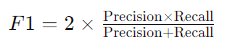


a table was created to better vizulize the impacts  of TP,TN,FP,FN

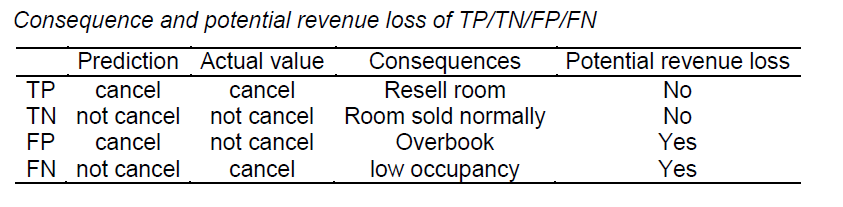


In [61]:
#lets do a decision tree model, using HPT to optimize f1 score
dt_base = DecisionTreeClassifier(random_state=42)

In [62]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train, scoring='f1', n_splits=5):
    '''
    This function optimizes the hyperparameters for a classifier by searching over a specified hyperparameter grid. 
    It uses GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters. 
    The combination with the highest F1-score for class 1 (canceled bookings) is selected as the default scoring metric. 
    The function returns the classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = clf_grid.best_params_
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_, best_hyperparameters

In [63]:
# Hyperparameter grid for DT
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [13, 14, 15],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
   
}

In [64]:
# Call the function for hyperparameter tuning
best_dt, best_dt_hyperparams = tune_clf_hyperparameters(dt_base, param_grid_dt, X_train, y_train)
print('DT Optimal Hyperparameters: \n', best_dt_hyperparams)

DT Optimal Hyperparameters: 
 {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3}


In [65]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    The metrics are calculated specifically for class 1.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, pos_label=1),
                                recall_score(y_test, y_pred, pos_label=1),
                                f1_score(y_test, y_pred, pos_label=1),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])],
                          index=['Accuracy','Precision (Class 1)','Recall (Class 1)','F1-score (Class 1)','AUC (Class 1)'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [66]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Define a colormap
    royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
    royalblue_r = royalblue.reversed()

    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show() 


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     59255
           1       0.86      0.74      0.80     35301

    accuracy                           0.86     94556
   macro avg       0.86      0.83      0.84     94556
weighted avg       0.86      0.86      0.86     94556


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     14814
           1       0.82      0.71      0.76      8825

    accuracy                           0.83     23639
   macro avg       0.83      0.81      0.82     23639
weighted avg       0.83      0.83      0.83     23639



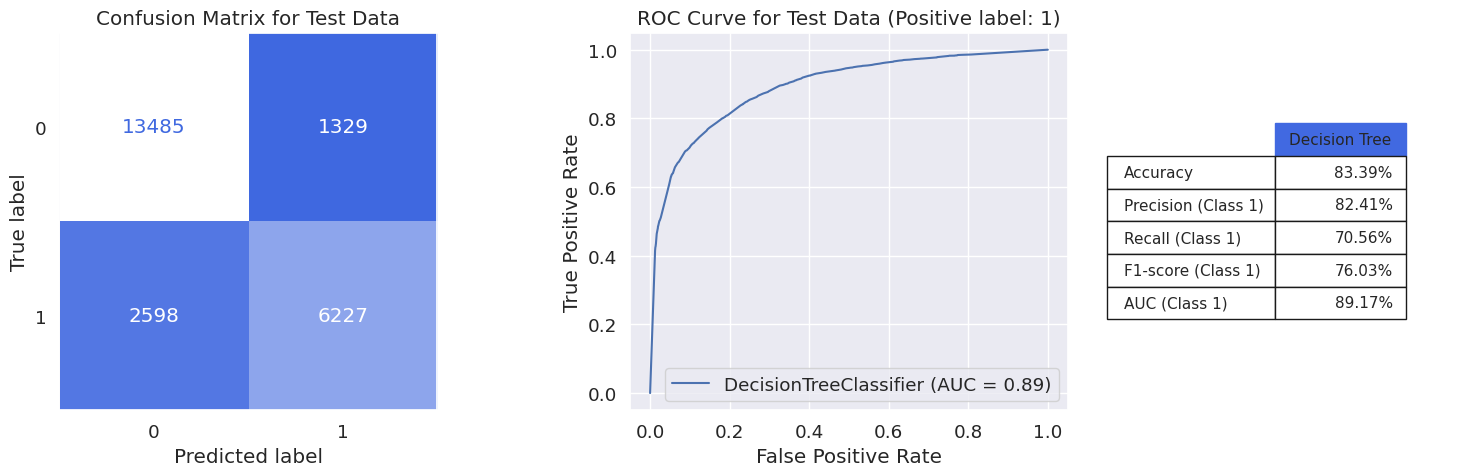

In [67]:
model_evaluation(best_dt, X_train, X_test, y_train, y_test, 'Decision Tree')

# analize the results of the model 
this desicion tree model givive us:

 86% acuracy meaning that the model is correctly predicting wether a booking will be canceled or not 86% of the times
 
 82% precision for class 1 in the test set meaning that 82% of the  bookings  that the model predicted as canceled  where actualy canceled
 
71% recal for class 1 in the test set  meaning that  the model actualy  correctly identified 71% of the actual cancelations

The F1-score for class 1 is 76%, which is the harmonic mean of Precision and Recall.

The AUC (Area Under the ROC Curve) for class 1 is 89%, which means that the model has a good discriminative power between the two classes.


additionally the model is not overfitting this can be seen because the metrics for the test set and the traian set are close  this ussualy indicates that the model  is generalizing good to unseen data

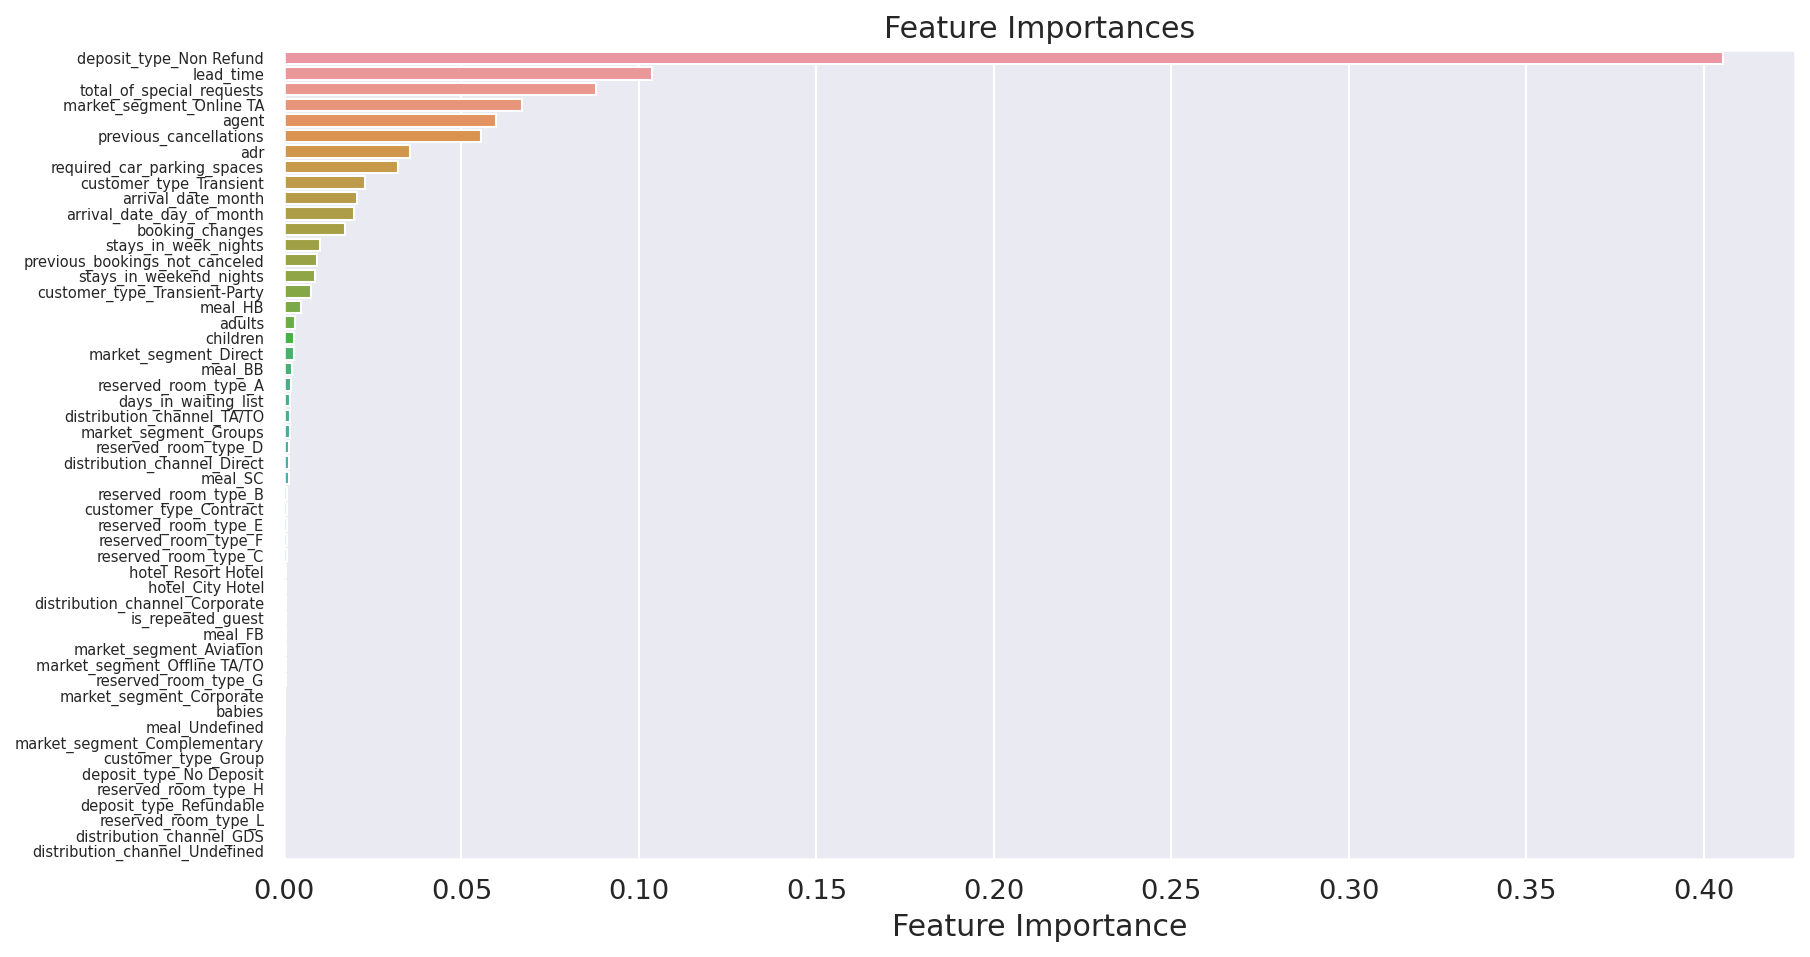

In [68]:
# Compute feature importances
feature_importances = best_dt.feature_importances_

# Sort the feature importances in descending order and get the indices
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(13, 7), dpi=150)
sns.barplot(x=feature_importances[sorted_indices], y=X.columns[sorted_indices], )
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.yticks(fontsize=7)
plt.show()

In [69]:
# now we save the results of this model 

In [70]:
dt_result = metrics_calculator(best_dt, X_test, y_test, 'Decision Tree')
dt_result

,Decision Tree
Accuracy,83.39%
Precision (Class 1),82.41%
Recall (Class 1),70.56%
F1-score (Class 1),76.03%
AUC (Class 1),89.17%


# random forest
random forest is a ensable tecnique of pruned decision trees, that means that the same classifier is trained on n data sets with the same size, for each sample a decision tree is built based on a random set of m features, from all the models trained  the predictions are combined using majoroty voting ( hard voting)

we use this model because :
It is a parallelizable algorithm that can scale to large datasets.

 it handles high-dimensional data and noisy data, and is robust to
overfitting


the probles that can arrive using this model in this data set are:
The model may not perform well on imbalanced datasets, as it may be biased towards the
majority class ( but we have used the stratified split data)

In [71]:
# now we will do a random forest model first we start by defining the model constructor 
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

In [72]:
# lets set up a hyper parameter grid to tune the rf model 
param_grid_rf = {
    'n_estimators': [100, 150],
    'criterion': ['entropy'],
    'max_depth': [16, 18],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    
}

In [76]:
# Using the tune_clf_hyperparameters function to get the best estimator
best_rf, best_rf_hyperparams = tune_clf_hyperparameters(rf_base, param_grid_rf, X_train, y_train)
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

KeyboardInterrupt: 

In [ ]:
model_evaluation(best_rf, X_train, X_test, y_train, y_test, 'Random Forest')

In [ ]:
# save the results of the rf moedel to further comparison
rf_result = metrics_calculator(best_rf, X_test, y_test, 'Random Forest')
rf_result

# analizing the results from the random forest model 

Accuracy :84,79%  the model is correctly predicting if a booking will be canceled or not 85% of the times 

Precision : 88% this means that 88% of the instances that the model predicted as canceled where actually canceled

Recal: 70 %  this means that  the model correctly identified 70% of the actual cancelations

f1: 77% the  harmonic mean between precision and recall is 77%

AUC : 92% so this model has a outstanding distinguish capability  between the 2 classes 


also the results from the train and test sets do not differ that much so we can affirm that the model is not overfiting

In [75]:
# lets compare the 2 models analized so far

results = pd.concat([dt_result, rf_result],axis=1)
results

NameError: name 'rf_result' is not defined

so far the random forest model has given us the best performance scores  only in recall the decision tree is better

In [ ]:
# since random forest is as the name indicate a tree based model lets compute the feature importance
# Compute feature importances
feature_importances = best_rf.feature_importances_

# Sort the feature importances in descending order and get the indices
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(13, 7), dpi=150)
sns.barplot(x=feature_importances[sorted_indices], y=X.columns[sorted_indices], )
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.yticks(fontsize=7)
plt.show()

as seen the type of deposits ,are the variables that mostly impact the classification , followed by the lead time wich is the time intreval that goes from the booking reservation and the arrival day  , them we have total of special rrequests  and previoust cancelations. this order of importance is pretty much expected. Because when ones make a non refundable booking of course they will not want to lose the money, the only exeption to this may be wen a costumer makes an insurance to the vacations that covers thee costs of cancelations but we do nort have informations about insurances so that will bo a nice research in the future. lead time is also straight forwar the thesys is as follows if a costumer books the hotel with a loot of time before many this may occur that will impede the stay also this is a commun behaviour for those who scavanger the weeb lokking for the best hotel price.  the number of special request can be intrepreted like this when a costumer makes special request it is costly both in monetary and time   or maybe the specyal request where made in that hotel because in the area only that hotel may offer that kind of special request so, also usually  pecial requests are made for special days and that kind of reservatons are harder to be canceled.

In [ ]:
#lets make a logistic regression model as well
lr_base= LogisticRegression(random_state=42, n_jobs=-1)

In [ ]:
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'sag', 'newton-cg'],
    'max_iter': [50, 100, 200, 500]
}

In [ ]:
# Using the tune_clf_hyperparameters function to get the best estimator
best_lr, best_lr_hyperparams = tune_clf_hyperparameters(lr_base, param_grid_lr, X_train, y_train)
print('RF Optimal Hyperparameters: \n', best_rf_hyperparams)

In [ ]:
model_evaluation(best_lr, X_train, X_test, y_train, y_test, 'Logistic Regression')

# analizing the results from the logistic regression  model
Accuracy :85% the model is correctly predicting if a booking will be canceled or not 85% of the times

Precision : 83% this means that 83% of the instances that the model predicted as canceled where actually canceled

Recal: 60 % this means that the model correctly identified 60% of the actual cancelations

f1: 70% the harmonic mean between precision and recall is 70%

AUC : 85% so this model has a good distinguish capability between the 2 classes


so far the Logistic regression model is the model that delivers the worst resutls

In [ ]:
# save the results of the rf moedel to further comparison
lr_result = metrics_calculator(best_lr, X_test, y_test, 'logistic Regression')
lr_result

# to finalize the analisys lets do a XGBOOST model

we will use the GradientBoostingClassifier because this is a great model for binary classification as well as linear regression but of course we are only intersted in the binary classification part.

description of the model from sklearn library:
This algorithm builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the loss function, e.g. binary or multiclass log loss. Binary classification is a special case where only a single regression tree is induced

we are gonna pas the 
use_label_encoder=False because we have already encoded variables and to avoid warnings about the features
the criterion is set to logloss because its better for binary classification

In [ ]:
# Define the model xgboost model 
xgb_base = xgb.XGBClassifier(use_label_encoder=False, criterion='log_loss', random_state=42)

In [ ]:
#define the parameter grid using the most important parameters
param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1,(y_train == 0).sum() / (y_train == 1).sum()],
    'n_estimators': [100, 200, 300]
}

In [ ]:
# Call the function for hyperparameter tuning
best_xgb, best_xgb_hyperparams = tune_clf_hyperparameters(xgb_base, param_grid_xgb, X_train, y_train)
print('XGBoost Optimal Hyperparameters: \n', best_xgb_hyperparams)

In [ ]:
model_evaluation(best_xgb, X_train, X_test, y_train, y_test, 'XGBoost')

In [ ]:
# Save the final performance of XGBoost classifier
xgb_result = metrics_calculator(best_xgb, X_test, y_test, 'XGBoost')
xgb_result

The XGBOOST model :
Accuracy : from all the predictions this model made 85% where correct
precission : from all the predictions clasified as canceled 80% where actualy canceled

recall : the moded corretly identified 80% of the actual cancelations

f1: the harmonic mean between recall and precision is 80% 

AUC : the distinguis capabillity of the model is 92% so pretty good 

the performance values for class 1 and 0 are pretty simmilar so there is no indication of overfitting 

the xgboost model is a tree model so we can compute the feature importance  so lets do it to asses wich features mostly impact the prediction 

In [ ]:
# Compute feature importances
feature_importances = best_xgb.feature_importances_

# Sort the feature importances in descending order and get the indices
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(13, 7), dpi=150)
sns.barplot(x=feature_importances[sorted_indices], y=X.columns[sorted_indices], )
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.yticks(fontsize=7)
plt.show()

As it can be seen the deposit type_nonNrefund is the moast important feature predicting wether a booking will be canceled or not just like in the random forest model, the previoust cancelations and the number of special requests are also pretty important in this model just like in the random forest, this is a good sign showing consistency of the features importance 

In [ ]:
# Concatenate previous classifiers perfermance results into a single dataframe
results = pd.concat([dt_result, rf_result, xgb_result,lr_result], axis=1).T

# Sort the dataframe in descending order based on F1-score (class 1) values
results.sort_values(by='F1-score (Class 1)', ascending=False, inplace=True)

# Color the F1-score column
results.style.applymap(lambda x: 'background-color: royalblue', subset='F1-score (Class 1)')

So the best performing model so far is XGBoost i nthe metric that we consider more important  the f1 score  it is not the best in the precission score but is the best for recall by a large margin  also it has the biggest AUC score so it has the best capability to distinguis between the 2 classes.
